# Solution - Group Challenge 1: Measure Region Properties

Create a plugin to profile morphological features from cells. The plugin should enable users to:

1) Select an image layer
2) Choose what region properties to measure
3) Save the output to a specified path as a CSV file

- Watch [this demo video](https://youtu.be/5iH57E09cAE) to see the plugin in action

In [3]:
from skimage import data
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np

import napari
from magicgui import magicgui

from napari.layers import Image
from napari.types import LabelsData
import pathlib

## Load sample data

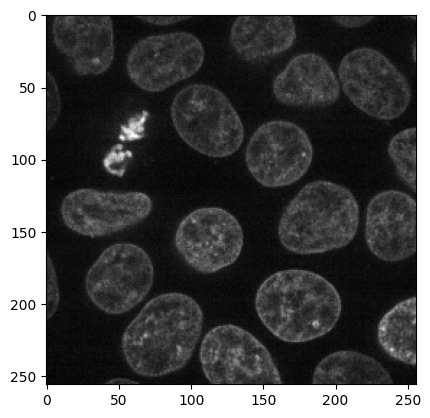

In [4]:
IMAGE2D = data.cells3d()[30,1]

plt.imshow(IMAGE2D, cmap='gray')

## Define plugin functions

In [5]:
def segment_cells(img):
    from cellpose import models
    
    model = models.CellposeModel(gpu=True)
    img = img_as_float(img)
    mask, __, __ = model.eval(img)
    
    return mask

def get_properties(mask, img):
    from skimage.measure import regionprops 
    
    return regionprops(mask, img)
    
def save_props_table(props, mask, properties, path):
    import pandas as pd

    prop_list = []
    for index in range(1, mask.max()):
        prop_list.append([index] + [props[index][prop_name] for prop_name in properties])
    prop_array = np.asarray(prop_list)
    df = pd.DataFrame(prop_array, columns=['CellID'] + properties)
    df.to_csv(path)

## Magicgui implementation

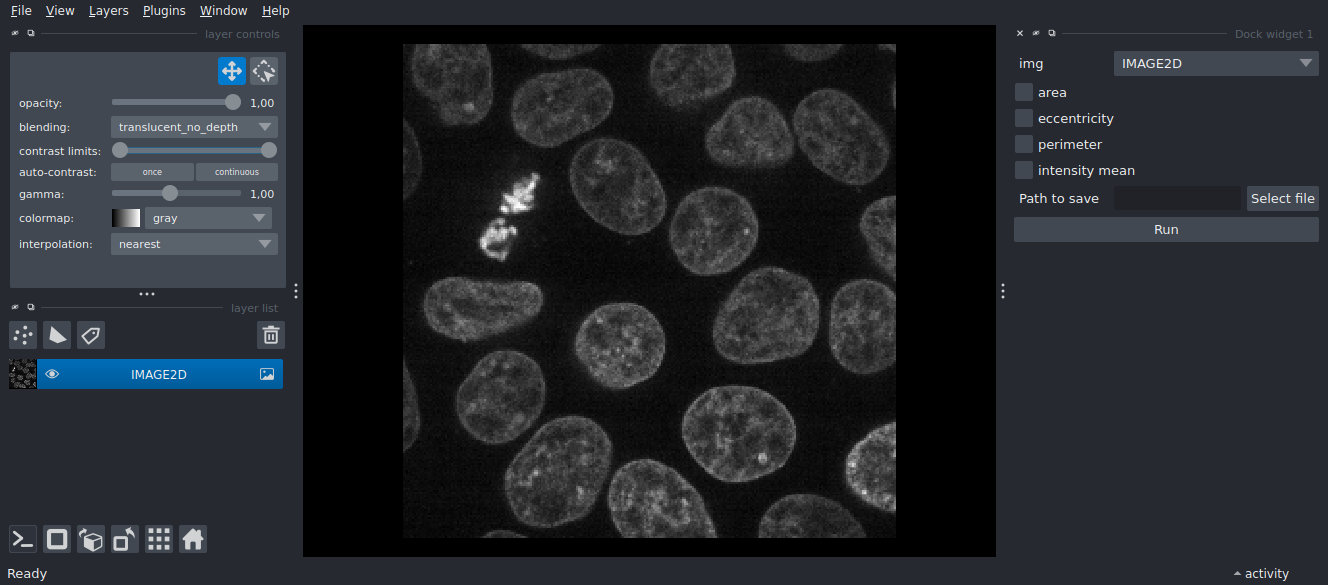

In [6]:
@magicgui(path={'label': 'Path to save',
                'widget_type': 'FileEdit',
                'mode': 'w',
                'filter': '*.csv'})
def measure_regionprops(
    img: 'napari.layers.Image', 
    area: 'bool',
    eccentricity: 'bool',
    perimeter: 'bool',
    intensity_mean: 'bool',
    path: 'pathlib.Path.home()'
):

    properties = []

    if area:
        properties.append('area')
    if eccentricity:
        properties.append('eccentricity')
    if perimeter:
        properties.append('perimeter')
    if intensity_mean:
        properties.append('intensity_mean')
    
    mask = segment_cells(img.data)
    props = get_properties(mask, img.data)
    save_props_table(props, mask, properties, path)
    

viewer = napari.view_image(IMAGE2D)
viewer.window.add_dock_widget(measure_regionprops)
napari.utils.nbscreenshot(viewer)

## Magic Factory Implementation

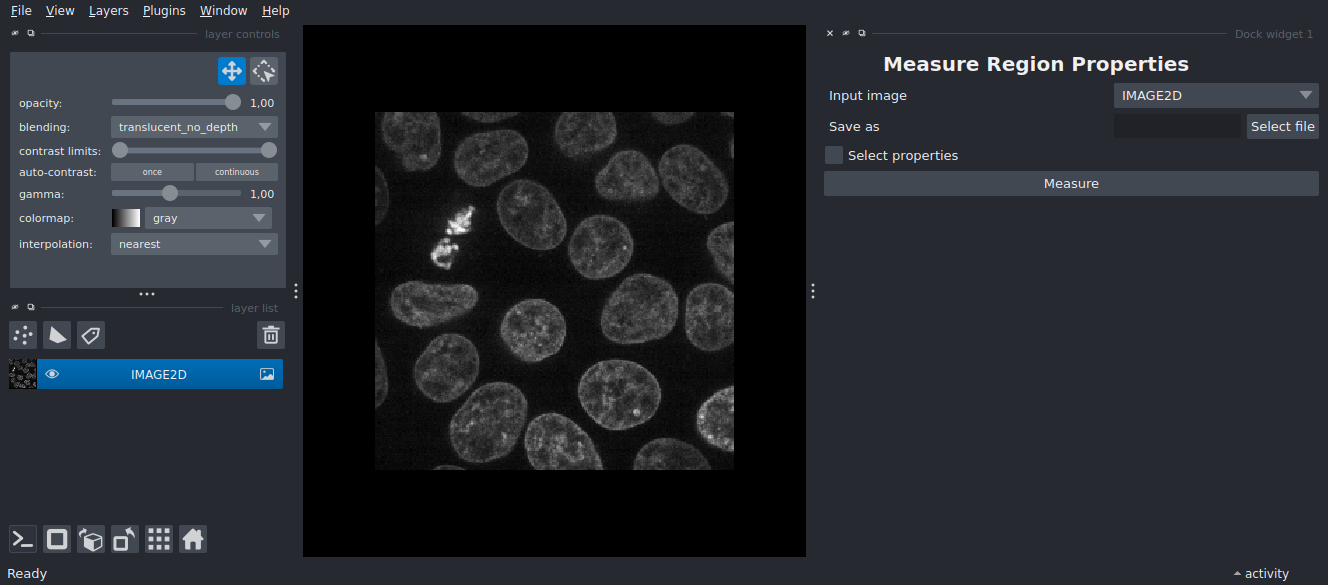

In [7]:
from magicgui import magic_factory   

def on_init(widget):
    properties = ['area', 'eccentricity', 'perimeter', 'intensity_mean', 'properties_header']

    for x in properties:
        setattr(getattr(widget, x), 'visible', False)

    def toggle_show_properties(show_properties: bool):
        if show_properties:
            for x in properties:
                setattr(getattr(widget, x), 'visible', True)  
        else:
            for x in properties:
                setattr(getattr(widget, x), 'visible', False)      

    widget.show_properties.changed.connect(toggle_show_properties)
    
@magic_factory(
    widget_init=on_init, layout='vertical', call_button='Measure',
    widget_header={'widget_type': 'Label',
                   'label': f'<h2 text-align="left">Measure Region Properties</h2>'},
    img={'label': 'Input image'},
    path={'label': 'Save as',
          'widget_type': 'FileEdit',
          'mode': 'r',
          'filter': '*.csv'},
    show_properties={'label': 'Select properties',
                     'widget_type': 'CheckBox',
                     'value': False},
    properties_header={'widget_type': 'Label',
                       'label': f'<h3 text-align="left">Select Region Properties</h3>'},
    area={'label': 'Area',
          'widget_type': 'CheckBox',
          'value': True},
    eccentricity={'label': 'Eccentricity',
                  'widget_type': 'CheckBox',
                  'value': True},
    perimeter={'label': 'Perimeter',
               'widget_type': 'CheckBox',
               'value': True},
    intensity_mean={'label': 'Mean intensity',
                    'widget_type': 'CheckBox',
                    'value': True}
)
def measure_regionprops(
    viewer: 'napari.viewer.Viewer',
    widget_header,
    img: 'napari.layers.Image',
    path,
    show_properties,
    properties_header,
    area,
    eccentricity,
    perimeter,
    intensity_mean
):

    properties = []
    
    if area:
        properties.append('area')
    if eccentricity:
        properties.append('eccentricity')
    if perimeter:
        properties.append('perimeter')
    if intensity_mean:
        properties.append('intensity_mean')

    
    mask = segment_cells(img.data)

    viewer.add_labels(mask)
    
    props = get_properties(mask, img.data)
    save_props_table(props, mask, properties, path)    
    
viewer = napari.view_image(IMAGE2D)
widget = measure_regionprops()
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)